# Лабораторная работа №2: "Вулканическая баллистика"

## Библиотеки

In [1]:
from numpy.random import Generator, PCG64
from scipy.optimize import root_scalar, brentq, fsolve, minimize_scalar
from typing import Dict, List
import matplotlib.pyplot as plt
import numpy as np
import simpy
from tqdm import tqdm
import pandas as pd

## Класс бомбы

In [2]:
class Bomb:
    
    g = np.array([0,0,-9.82])
    
    def __init__(self,
                 t_erup: float,
                 r0: np.ndarray,
                 v0: np.ndarray,
                 mass: float,
                 radius: float):
        self.t_erup = t_erup
        self.r = r0
        self.v = v0
        self.m = mass
        self.R = radius
        self.is_coll = False
    
    def calc_r(self, t: float):
        """Рассчитать радиус-вектор в момент времени `t`."""
        return 1/2 * self.g * (t - self.t_erup)**2 + self.v * (t - self.t_erup) + self.r
    
    def calc_v(self, t: float):
        """Рассчитать вектор скорости в момент времени `t`."""
        return self.v + self.g * (t - self.t_erup)
    
    def is_collided(self):
        """Столкивался ли камень."""
        return False
    
    def xy_fall(self):
        """Координаты падения."""
        return self.calc_r(when_ground(self))[:-1]

## Модель

Глобальные списки летящих камней и камней на земле, а также словарь (хэш-таблица) процессов каждого экземпляра бомбы:

In [3]:
flyings, fallens = [], []
processes: Dict[Bomb, List[simpy.Process]] = {}

Функция формирования генератора чисел:

In [4]:
def get_rand_state(seed: int = None):
    return Generator(PCG64(seed))

Процесс выброса камней при извержении. Всего таких процессов при моделировании `n_erups`:

In [47]:
def eruption(env: simpy.Environment, dt: float, n: int, rs: Generator, allow_colision):
    """Процесс (в терминах `SimPy`) i-го выброса камней.
    
    env :
        Объект среды `SimPy`,
        отвечающий за управление и обработку событий.
    dt :
        Задержка начала процесса.
    n :
        Число выбрасываемых камней.
    rs :
        Генератор чисел.
    """
    yield env.timeout(dt)
    BOMBS = gen_bombs(env, n, rs)
    for BOMB in BOMBS:
        time = when_ground(BOMB)
        processes[BOMB] = []
        processes[BOMB].append(env.process(ground(env, time, BOMB)))
        if allow_colision:
            for BOMB_f in flyings:
                if BOMB_f is BOMB:
                    continue
                t_col = when_collision(BOMB, BOMB_f)
                if t_col is np.inf:
                    continue
                processes[BOMB].append(env.process(collision(env, t_col, BOMB, BOMB_f)))
        flyings.append(BOMB)

Функция генерации камней:

In [48]:
R_c, D_c = 100, 10
H = 122
mu_s, sigma_s = 18, 2.5
mu_teta, sigma_teta = 70/180*np.pi, 15/180*np.pi
R_min, R_max = 1.5, 3.5
rho = 6700

In [5]:
def gen_bombs(env: simpy.Environment, n: int, rs: Generator):
    """Сгенерировать n бомб (камней).

    env :
        Объект среды `SimPy`,
        отвечающий за управление и обработку событий.
    n :
        Число выбрасываемых камней.
    rs :
        Генератор чисел.
    """
#     r0 = np.array([])
#     for bomb in range(n):
#         v0 = vel_rand()
#         mass = random.choice(mass_list)
#         radius = random.choice(radius_list)
#         Bomb(env.now, r0, v0, mass, radius)
        
    r = rs.uniform(low=1e-5, high=R_c, size=n)
    z = rs.uniform(low=H-D_c, high=H, size=n)
    fi = rs.uniform(low=0, high=2*np.pi, size=n)
    teta = rs.normal(loc=mu_teta, scale=sigma_teta, size=n)
    vel = rs.normal(loc=mu_s, scale=sigma_s, size=n)
    R = rs.uniform(low=R_min, high=R_max, size=n)
    bombs = []
    
    for i in range(n):
        teta[i] = max(0, teta[i])
        vel[i] = max(2 ,vel[i])
        BOMB = Bomb(
                t_erup=env.now,
                r0=np.array([r[i]*np.cos(fi[i]), r[i]*np.sin(fi[i]), z[i]]),
                v0=np.array([vel[i]*np.cos(teta[i])*np.cos(fi[i]), vel[i]*np.cos(teta[i])*np.sin(fi[i]), vel[i]*np.sin(teta[i])]),
                mass=4/3*np.pi*R[i]**3*rho,
                radius=R[i])
        bombs.append(BOMB)
    return bombs

Функция-**процесс**, отвечающая действию при событии `GROUND`:

In [50]:
def ground(env: simpy.Environment, dt: float, b: Bomb):
    """Процесс (в терминах `SimPy`), происходящий при наступлении
    события `GROUND`.
    
    env :
        Объект среды `SimPy`,
        отвечающий за управление и обработку событий.
    dt :
        Задержка начала процесса.
    b :
        Бомба (камень).
    """
    try:
        yield env.timeout(dt)
        clear_queue(b)
        if b in flyings:
            flyings.remove(b)
        fallens.append(b)
    except simpy.Interrupt:
        return

Функция-**процесс**, описывающая действие при событии `COLLISION`:

In [51]:
def collision(env: simpy.Environment, dt: float, b1: Bomb, b2: Bomb):
    """Процесс (в терминах `SimPy`), происходящий при наступлении
    события `COLLISION`.
    
    env :
        Объект среды `SimPy`,
        отвечающий за управление и обработку событий.
    dt :
        Задержка начала процесса.
    b1 и b2 :
        Бомбы.
    """
    try:
        yield env.timeout(dt)
        
        clear_queue(b1)
        clear_queue(b2)
        b1.t_erup, b2.t_erup = env.now, env.now
        b1.r, b2.r = b1.calc_r(env.now), b2.calc_r(env.now)
        b1.v, b2.v = calc_collision(env.now, b1, b2)
        b1.is_coll, b2.is_coll = True, True
        
        for b in [b1, b2]:
            
            time = when_ground(b)
            processes[b].append(env.process(ground(env, time, b)))
            
            for bb in flyings:
                if bb is b:
                    continue
                t_col = when_collision(b, bb)
                if t_col is np.inf:
                    continue
                processes[b].append(env.process(collision(env, t_col, b, bb)))
                
    except simpy.Interrupt:
        return

Функция очистки очереди событий, связанных с бомбой `b`:

In [52]:
def clear_queue(b: Bomb):
    for proc in processes[b]:
        try:
            proc.interrupt()
        except RuntimeError:
            continue

Функция расчёта времени падения камня на землю ($z=0$):

In [53]:
def when_ground(b: Bomb):
    r_z = b.r[-1]
    v_z = b.v[-1]
    g_z = b.g[-1]
    time = (-v_z - np.sqrt(v_z**2 - 2*g_z*r_z))/g_z
    if time < 0:
        raise ValueError("time < 0")
    return time+b.t_erup

Функция расчёта скоростей бомб `b1` и `b2` после их столкновения в момент времени `t`:

In [54]:
def calc_collision(t: float, b1: Bomb, b2: Bomb, c=0.8):
    v_1 = b1.calc_v(t)
    v_2 = b2.calc_v(t)
    norm = (b1.calc_r(t) - b2.calc_r(t))/np.linalg.norm(b1.calc_r(t) - b2.calc_r(t))
    v_c = -(v_1 - v_2)*norm
    v_s = -v_c
    d_v_s = -c*v_s - v_s
    p = b1.m*b2.m/(b1.m+b2.m)*d_v_s*norm
    return v_1 + p/b1.m, v_2 + p/b2.m

Функция расчёта момента времени столкновения камня `b1` с камнем `b2`:

In [55]:
def when_collision(b1: Bomb, b2: Bomb):
    
    def dist(t):
        dist = np.linalg.norm(b1.calc_r(t) - b2.calc_r(t))
        if dist <= b1.R + b2.R:
            return 0
        return dist
    
    time_l = max(b1.t_erup, b2.t_erup)
    time_r = min(when_ground(b1), when_ground(b2))
    
    if time_l >= time_r:
        return np.inf
    
    result = minimize_scalar(dist, method='bounded', bounds=(time_l, time_r))
    
    if not result.success:
        print(result)
        return np.inf
    
    if result.fun <= b1.R + b2.R:
        return result.x
    
    return np.inf

Функция-**процесс** моделирования извержения:

In [56]:
def simulation(env: simpy.Environment,
               n_erups: int,
               rs: Generator,
               allowed_collisions=False):
    """Процесс (в терминах `SimPy`) моделирования.
    
    env :
        Объект среды `SimPy`,
        отвечающий за управление и обработку событий.
    n_erups :
        Количество извержений.
    rs :
        Генератор чисел.
    allowed_collisions :
        Столкновения возможны (`True`) или нет (`False`).
    """
    betta = 90
    n_bombs = np.random.randint(1, 100)
    
    for i in tqdm(range(n_erups)):
        time = rs.exponential(scale=betta)
        yield env.process(eruption(env, time, n_bombs, rs, allowed_collisions))

Функция **запуска** моделирования извержения (с или без учёта столкновения камней):

In [57]:
def simulate(n_erups: int,
             allowed_collisions=False,
             seed: int = None):
    """Запустить моделирование извержения.
    
    n_erups:
        Количество извержений.
    allowed_collisions :
        Столкновения возможны (`True`) или нет (`False`).
    seed:
        Затравка для генератора чисел.
    """
    env = simpy.Environment()
    rs = get_rand_state(seed)
    env.process(simulation(env, n_erups, rs, allowed_collisions))
    env.run() # until=10

Основная функция компьютерной модели:

In [58]:
def main(n_erups: int,
         allowed_collisions: bool,
         seed: int = None):
    """Главная функция - точка входа в программу.
    
    n_erups :
        Количество извержений.
    """
    simulate(n_erups, allowed_collisions, seed)
    print('done')

## Моделирование

In [36]:
n_erups = 12 # Назначайте любое значение, но не менее 12
allowed_collision = True
main(n_erups, allowed_collision, 3033)

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:10<00:00,  1.18it/s]


done


In [37]:
points = [{'x': b.xy_fall()[0], 'y': b.xy_fall()[1], 'collision':b.is_coll } for b in fallens]

In [38]:
tabel_points = pd.DataFrame(points)

In [39]:
allowed_collision

True

In [40]:
tabel_points.to_csv("collision.csv") if allowed_collision else tabel_points.to_csv("not_collision.csv")

## Визуализация

Универсальная функция визуализации точек падения камней:

In [6]:
df_col = pd.read_csv("collision.csv")
df_col_col = df_col.loc[df_col["collision"] == True]
df_col_not_col = df_col.loc[df_col["collision"] != True]
df_not_col = pd.read_csv("not_collision.csv")

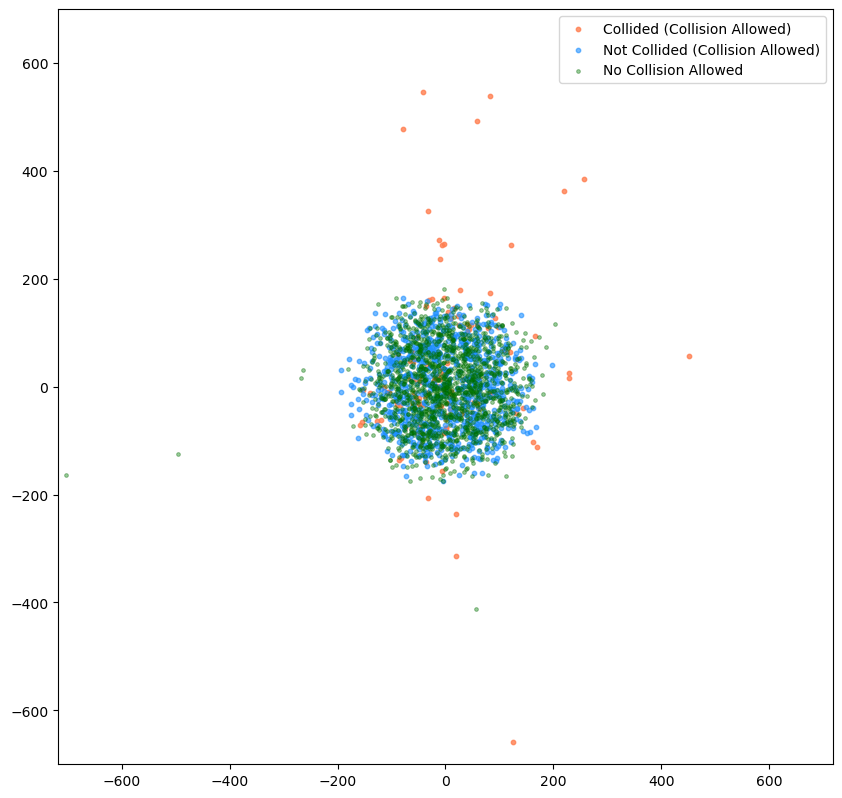

In [11]:
fig = plt.figure(figsize=(10, 10), dpi=100)

plt.scatter(df_col_col['x'], df_col_col['y'], c='coral', s=10, alpha=0.8, marker='o', label='Collided (Collision Allowed)')
plt.scatter(df_col_not_col['x'], df_col_not_col['y'], c='dodgerblue', s=10, alpha=0.6, marker='o', label='Not Collided (Collision Allowed)')
plt.scatter(df_not_col['x'], df_not_col['y'], c='g', edgecolor='darkgreen', linewidth=0.7, s=7, alpha=0.4, marker='o', label='No Collision Allowed')

plt.axis('equal')
plt.xlim(-700, 700)
plt.ylim(-700, 700)

plt.legend()
plt.show()

## Рекомендации

* Используйте функции [`save`](https://numpy.org/doc/stable/reference/generated/numpy.save.html) и/или [`savez`](https://numpy.org/doc/stable/reference/generated/numpy.savez.html) библиотеки `NumPy` для сохранения точек падения. Вам не нужно будет хранить все полученные данные в оперативной памяти. После моделирования вы сможете читать данные в другой части кода, отделённой от той его части, которая отвечает за моделирование.
* Решить уравнение встречи бомб можете численным методом [`root_scalar`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.root_scalar.html) из пакета `SciPy`.
* Используйте библиотеку дискретно-событийного моделирования [`SimPy`](https://simpy.readthedocs.io/en/latest/), чтобы не изобретать велосипед. Либо реализуйте программу согласно псевдокоду с лекции по теме дискретно-событийного моделирования.